## WEEK 5. Эксперименты с моделью прогнозирования оттока.

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решение.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. Подробные инструкции даны в приложенном jupyther notebook.

In [211]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [212]:
train_data = pd.read_csv("orange_small_churn_train_data.csv")
test_data = pd.read_csv("orange_small_churn_test_data.csv")
data = pd.concat((train_data.iloc[:,:-1], test_data), axis=0).drop(columns=['ID'])
y = train_data.iloc[:,-1].fillna(-1.0)

In [213]:
#удалим переменные, у которых пропущенно более 70% данных:
NaN_num = (data.iloc[:, 0:190].isna().sum(axis = 0)/data.shape[0])
NaN_cat = (data.iloc[:, 190:].isna().sum(axis = 0)/data.shape[0])

NaN_num_del=[]
for i in range(NaN_num.shape[0]):
    if NaN_num[i]>=0.7: NaN_num_del.append(NaN_num.index[i])
NaN_cat_del=[]
for i in range(NaN_cat.shape[0]):
    if NaN_cat[i]>0.7: NaN_cat_del.append(NaN_cat.index[i])
        
X_num = data.iloc[:, 0:190].drop(columns=NaN_num_del)
X_cat = data.iloc[:, 190:].drop(columns=NaN_cat_del)

In [174]:
#заполняем пропуски у числовых фич средним значением
X_num = X_num.fillna(X_num.mean())  

In [ ]:
#удалим признаки, у которых более 50 различных категорий
unique = []
for j in X_cat.columns:
    if len(X_cat[j].dropna().unique())>50: unique.append(j)

X_cat = X_cat.drop(columns=unique)

In [54]:
X_cat = pd.get_dummies(X_cat, dummy_na=True)    #примением Onehotencoding

In [64]:
#Объединим числовые и категориальные признаки
common_data = pd.concat((X_num, X_cat), axis=1)

X = common_data.iloc[:-10000,:]
X_kaggle = common_data.iloc[-10000:,:]

### Модель

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [177]:
GBclf = GradientBoostingClassifier(random_state=1)
cv_strategy = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

In [17]:
#Проверка модели на кросс-валидации
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7199740073732313

# Инструкции

# 1

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [ ]:
train_sizes, train_scores, test_scores=learning_curve(GBclf, X, y, train_sizes=np.linspace(0.1, 1, 10), scoring="roc_auc", cv=5)

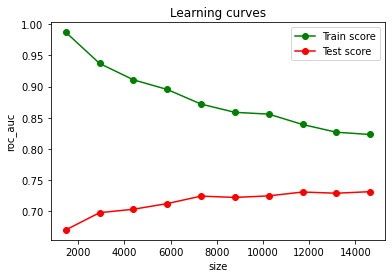

In [242]:
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="g", label="Train score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', color="r", label="Test score")
plt.xlabel("size")
plt.ylabel("roc_auc")
plt.title('Learning curves')
plt.legend(loc="best")
plt.show()

##### Рост качества на тестовой выборке замедляется примерно с 12000 объектов, но тем не менее качество растет, модель строится быстро, поэтому оставим все объекты в выборке.

# 2

2. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [18]:
print('Не отток:{}'.format(sum(y==-1)))
print('Oтток:{}'.format(sum(y==1)))

Не отток:16922
Oтток:1377


1) Балансировка 20/80 (не отток/отток)

In [30]:
w0=0.2
w1=0.8
weights = np.array([w0 if r==-1 else w1 for r in y_train])
balance_20_80 = cross_val_score(GBclf, X_train, y_train, cv=cv_strategy, scoring='roc_auc', 
                                fit_params={'sample_weight': weights}, ).mean()
print ('Balance 20/80:  {}'.format(balance_20_80))

Balance 20/80:0.7172549711533766


2) Балансировка 80/20 (не отток/отток)

In [32]:
w0=0.8
w1=0.2
weights = np.array([w0 if r==-1 else w1 for r in y_train])
balance_80_20 = cross_val_score(GBclf, X_train, y_train, cv=cv_strategy, scoring='roc_auc', 
                                fit_params={'sample_weight': weights}, ).mean()
print ('Balance 80/20: {}'.format(balance_80_20))

Balance 80/20: 0.7191785870640565


3) Балансировка 50/50 (не отток/отток)

In [33]:
w0=0.5
w1=0.5
weights = np.array([w0 if r==-1 else w1 for r in y_train])
balance_50_50 = cross_val_score(GBclf, X_train, y_train, cv=cv_strategy, scoring='roc_auc', 
                                fit_params={'sample_weight': weights}, ).mean()
print ('Balance 50/50: {}'.format(balance_50_50))

Balance 50/50: 0.7189936650704152


4) Балансировка 70/30 (не отток/отток)

In [36]:
w0=0.7
w1=0.3
weights = np.array([w0 if r==-1 else w1 for r in y_train])
balance_70_30 = cross_val_score(GBclf, X_train, y_train, cv=cv_strategy, scoring='roc_auc', 
                                fit_params={'sample_weight': weights}, ).mean()
print ('Balance 70/30: {}'.format(balance_70_30))

Balance 70/30: 0.718810360652965


5) Балансировка 60/40 (не отток/отток)

In [35]:
w0=0.6
w1=0.4
weights = np.array([w0 if r==-1 else w1 for r in y_train])
balance_60_40 = cross_val_score(GBclf, X_train, y_train, cv=cv_strategy, scoring='roc_auc', 
                                fit_params={'sample_weight': weights}, ).mean()
print ('Balance 60/40: {}'.format(balance_60_40))

Balance 60/40: 0.7196468024665167


6) Балансировка 55/45 (не отток/отток)

In [38]:
w0=0.55
w1=0.45
weights = np.array([w0 if r==-1 else w1 for r in y_train])
balance_55_45 = cross_val_score(GBclf, X_train, y_train, cv=cv_strategy, scoring='roc_auc', 
                                fit_params={'sample_weight': weights}, ).mean()
print ('Balance 55/45: {}'.format(balance_55_45))

Balance 55/45: 0.719775502296138


##### Лучший результат дала балансировка 55/45, но оценка все равно ниже, чем без балансировки.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количеству отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [359]:
data_train = pd.concat([X_train, y_train], axis=1)

count_no_outflow, count_outflow = y_train.value_counts()

#Возьмем из группы "не отток" столько же элементов, сколько в оттоке
df_no_outflow = data_train[data_train['labels'] == -1]
df_outflow = data_train[data_train['labels'] == 1]
df_no_outflow_under = df_no_outflow.sample(count_outflow)
data_undersampling = shuffle(pd.concat([df_no_outflow_under, df_outflow], axis=0))

print('Random under-sampling:')
print(data_undersampling.labels.value_counts())

X_train1 = data_undersampling.iloc[:,:-1]
y_train1 = data_undersampling.iloc[:,-1]

Random under-sampling:
-1.0    964
 1.0    964
Name: labels, dtype: int64


In [360]:
cross_val_score(GBclf, X_train1, y_train1, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7026243720760308

In [363]:
#Уберем конец в классе "не отток", оставив 10% от выборки, чтобы примерно уравновесить кол-во объектов разных классов
df_no_outflow = data_train[data_train['labels'] == -1].iloc[:int(count_no_outflow/10), :]
df_outflow = data_train[data_train['labels'] == 1]
data_undersampling = shuffle(pd.concat([df_no_outflow, df_outflow], axis=0))

print('First undersampling:')
print(data_undersampling.labels.value_counts())

X_train2 = data_undersampling.iloc[:,:-1]
y_train2 = data_undersampling.iloc[:,-1]

First undersampling:
-1.0    1184
 1.0     964
Name: labels, dtype: int64


In [364]:
cross_val_score(GBclf, X_train2, y_train2, scoring = 'roc_auc', cv=cv_strategy).mean()

0.6967379807095515

In [366]:
#Уберем начало в классе "не отток", оставив 10% от выборки, чтобы примерно уравновесить кол-во объектов разных классов
df_no_outflow = data_train[data_train['labels'] == -1].iloc[-int(count_no_outflow/10):, :]
df_outflow = data_train[data_train['labels'] == 1]
data_undersampling = shuffle(pd.concat([df_no_outflow, df_outflow], axis=0))

print('Last undersampling:')
print(data_undersampling.labels.value_counts())

X_train3 = data_undersampling.iloc[:,:-1]
y_train3 = data_undersampling.iloc[:,-1]

Last undersampling:
-1.0    1184
 1.0     964
Name: labels, dtype: int64


In [367]:
cross_val_score(GBclf, X_train3, y_train3, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7021708244958071

##### Во всех трех случаях качество значительно снизилось, поэтому не будем делать Undersampling

# 3

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Заполним пропуски у числовых переменных нулями. Для этого в третьей сверху ячейки с кодом заменим код на: X_num = X_num.fillna(0). Все остальные ячейки по обработке данных и построению модели оставляем без изменений, запускаем их, после проверяем качество на кросс-валидации:

In [49]:
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7151944046353628

Попробуем заполнить пропуски аномальными значениями: -999. Код соотвественно X_num = X_num.fillna(-999)

In [57]:
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.71290703343088

##### В обоих случаях качество снизилось, поэтому оставляем изначальный вариант заполнения средними значениями

# 4

4. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Попробуем стратегию LabelEncoder(). Для этого нужно выполнить первые три ячейки с кодом, затем указанную ниже ячейку, пропустить ячейку с удалением категориальных признаков, у которых более 50 разных категорий, пропустить ячейку с Onehotencoder, остальные ячейки выполнить по порядку.

In [ ]:
X_cat = X_cat.fillna('Na', axis=0).applymap(str)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for j in range(X_cat.shape[1]):
    le.fit(X_cat.iloc[:,j])
    X_cat.iloc[:,j] = le.transform(X_cat.iloc[:,j])

In [66]:
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.721599828646281

Заменим каждую категорию числом входящих в неё объектов (запуск ячеек аналогично тому, как было в предыдущих пунктах).

In [ ]:
X_cat = X_cat.fillna('Na', axis=0).applymap(str)

for j in range(X_cat.shape[1]):                            
    X_cat.iloc[:,j] = X_cat.iloc[:,j].map(X_cat.groupby(X_cat.columns[j]).size())   

In [84]:
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7237989268953984

##### Оставляем последний вариант (каждая ячейка заполнена числом входящих в нее объектов), т.к. при такой обработке модель показывает наилучшее качество

# 5

5. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль sklearn.feature_selection). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (sklearn.linear_model.Lasso). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Выше применена следующая стратегия: удаление признаков, у которых пропущено более 70% данных, и дополнительно удаление категориальных признаков, у которых более 50 различных категорий. Попробуем другие стратегии.

* Проведем отбор на основе важности признаков через feature_importances_ построенной модели. Удалим признаки с нулевой важностью (среди уже отобранных признаков) и построим модель на новом наборе признаков. 

In [101]:
X.shape

(18299, 74)

In [102]:
GBclf.fit(X,y)
importance = GBclf.feature_importances_
importance = pd.DataFrame({"Feature": X.columns, "Importance": importance}) 
importance = importance.sort_values(by = importance.columns[1])

In [103]:
import_del=[]
for i in range(importance.shape[0]):
    if importance.Importance[i]==0: import_del.append(importance.Feature[i])

In [104]:
X_importance = X.drop(columns=import_del)
X_importance.shape

(18299, 65)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_importance, y, test_size=0.3, stratify=y, random_state=0)

In [106]:
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7239034564914838

Качество модели немного улучшилось. 

* Отбор наиболее связанных с целевой переменной признаков на основе статистического критерия. 
Применяем к обработанным ранее данным. 

In [178]:
select = SelectKBest(k=65)
select.fit(X, y)
X = select.transform(X)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [144]:
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7268796668212248

##### Отбираем 65 наиболее связанных с целевой переменной признаков (Пробовала разные варианты, но с числом признаков, равных 65, модель показала наилучший результат). 

# 6

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [159]:
GBclf.get_params().keys()

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [164]:
#Случайный поиск параметров по сетке
parameters_grid = {'n_estimators' : np.arange(70, 200, 10),
                  'learning_rate': np.arange(0.02, 0.12, 0.02),
                   'max_depth': np.arange(3, 10),
                   'max_features': np.arange(25, 75, 10),
                   'subsample': np.arange(0.2, 1.2, 0.2),
                  }
grid_cv = RandomizedSearchCV(GBclf, parameters_grid, scoring = 'roc_auc', cv = cv_strategy, n_iter=30, n_jobs=-1)

#'random_state': np.arange(0, 42)

In [165]:
%time
grid_cv.fit(X_train, y_train)  
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Wall time: 0 ns
0.7274880824590555
{'subsample': 1.0, 'n_estimators': 110, 'max_features': 45, 'max_depth': 3, 'learning_rate': 0.08}


In [166]:
#подбор параметров на основе предыдущего отбора
parameters = {'n_estimators' : np.arange(100, 130, 10),
              'learning_rate': np.arange(0.07, 0.1, 0.01),
              'max_depth': np.arange(2, 5),
              'max_features': np.arange(35, 65, 10),
              'subsample': [1]
              }
grid_cv = GridSearchCV(GBclf, parameters, scoring='roc_auc', n_jobs=-1, cv=cv_strategy)

In [167]:
%%time
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.731837197957033
{'learning_rate': 0.08, 'max_depth': 2, 'max_features': 35, 'n_estimators': 120, 'subsample': 1}
Wall time: 10min 52s


In [181]:
model_params = {'n_estimators': 120,
                'max_depth': 2,
                'learning_rate': 0.08,
                'max_features': 35,
                'subsample': 1
                }
GBclf = GradientBoostingClassifier(**model_params)

In [182]:
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7298722909927525

##### За счет подбора параметров качество модели улучшилось

# 7

7. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод feature_importances_ - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [186]:
importance = GBclf.feature_importances_
importance = pd.DataFrame({"Feature": X_importance.columns, "Importance": importance}) 
importance = importance.sort_values(by = importance.columns[1], ascending=False)
importance

,Feature,Importance
22,Var113,0.242900
33,Var160,0.101077
55,Var217,0.079165
19,Var94,0.077346
54,Var216,0.070274
...,...,...
23,Var119,0.000000
1,Var13,0.000000
31,Var149,0.000000
30,Var144,0.000000


##### В начале выведены признаки, внесшие наибольший вклад в модель, в конце - наименьший

# 8

8. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли между этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [189]:
GBclf = GradientBoostingClassifier(**model_params, random_state=1)
GBclf.fit(X_train, y_train)
predictions = GBclf.predict(X_test)

In [190]:
bad = [i for i, k in enumerate(zip(predictions, y_test.values)) if k[0]!=k[1]]

In [202]:
pd.DataFrame(X_test[bad,:])

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1321.124375,6.821836,1253.625278,236.344888,292.660892,4.530059,97.28745,224.440225,0.730775,2.578824e+06,...,14336.0,22917.0,46.0,20929.0,46.0,14781.0,737.0,19908.0,18485.0,16021.0
1,140.000000,0.000000,0.000000,332.000000,415.000000,4.000000,32.00000,209.120000,0.000000,2.807556e+06,...,13550.0,2898.0,24.0,20929.0,24.0,14781.0,1218.0,19908.0,18485.0,16021.0
2,3605.000000,28.000000,1636.000000,136.000000,170.000000,0.000000,24.00000,200.000000,0.000000,1.555200e+06,...,13550.0,22917.0,19.0,20929.0,19.0,6285.0,4552.0,19908.0,759.0,6665.0
3,924.000000,7.000000,440.000000,204.000000,255.000000,0.000000,80.00000,286.960000,0.000000,4.205574e+06,...,14336.0,22917.0,27.0,20929.0,27.0,14781.0,2720.0,19908.0,18485.0,6665.0
4,0.000000,0.000000,0.000000,8.000000,10.000000,0.000000,0.00000,334.400000,0.000000,0.000000e+00,...,13550.0,22917.0,27.0,20929.0,27.0,14781.0,4552.0,19908.0,18485.0,16021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1321.124375,6.821836,1253.625278,236.344888,292.660892,4.530059,97.28745,224.440225,0.730775,2.578824e+06,...,14336.0,22917.0,27.0,20929.0,27.0,14781.0,832.0,19908.0,18485.0,16021.0
409,252.000000,0.000000,0.000000,480.000000,600.000000,4.000000,280.00000,230.560000,0.000000,4.341006e+06,...,14336.0,22917.0,13.0,20929.0,13.0,14781.0,737.0,19908.0,18485.0,16021.0
410,1512.000000,7.000000,36.000000,288.000000,360.000000,10.000000,176.00000,166.560000,0.000000,2.094486e+06,...,14336.0,22917.0,1.0,1768.0,1.0,14781.0,2720.0,1331.0,18485.0,16021.0
411,959.000000,7.000000,392.000000,128.000000,160.000000,0.000000,0.00000,253.520000,0.000000,9.806400e+06,...,13550.0,22917.0,17.0,20929.0,17.0,14781.0,1456.0,19908.0,18485.0,16021.0


In [194]:
y_test.iloc[bad].value_counts()

 1.0    409
-1.0      4
Name: labels, dtype: int64

In [204]:
pd.DataFrame(X_test[bad,:]).describe()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,4.130000e+02,...,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,1056.378880,4.899724,739.444334,222.238295,274.721909,3.967902,85.755928,220.337063,0.904079,2.694469e+06,...,13057.927361,19368.595642,133.847458,17873.220339,133.847458,11877.002421,1945.769976,16434.261501,15133.895884,13080.530266
std,1400.938536,5.182667,1389.380341,365.872904,458.138247,7.965927,143.885408,74.404166,3.370172,2.897820e+06,...,3303.363296,7809.938694,459.130931,6908.466404,459.130931,4274.744694,1385.310132,7055.216443,6907.362623,4530.423679
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,413.000000,153.000000,1.000000,152.000000,1.000000,1298.000000,206.000000,336.000000,3.000000,5568.000000
25%,329.000000,0.000000,0.000000,116.000000,135.000000,0.000000,8.000000,176.560000,0.000000,3.742200e+04,...,13550.000000,22917.000000,14.000000,20929.000000,14.000000,6285.000000,814.000000,19908.000000,18485.000000,6665.000000
50%,784.000000,6.821836,60.000000,148.000000,180.000000,2.000000,48.000000,220.080000,0.000000,2.409168e+06,...,13550.000000,22917.000000,26.000000,20929.000000,26.000000,14781.000000,1456.000000,19908.000000,18485.000000,16021.000000
75%,1321.124375,7.000000,1253.625278,236.344888,292.660892,4.530059,97.287450,254.640000,0.000000,4.205574e+06,...,14336.000000,22917.000000,40.000000,20929.000000,40.000000,14781.000000,2720.000000,19908.000000,18485.000000,16021.000000
max,14798.000000,28.000000,10524.000000,4388.000000,5485.000000,122.000000,1680.000000,525.760000,30.000000,1.451520e+07,...,14336.000000,22917.000000,2534.000000,20929.000000,2534.000000,14781.000000,4552.000000,19908.000000,18485.000000,16021.000000


##### Сложно однозначно сказать, почему ошибка достигается именно на данных объектах, возможно они являются выбросами. Также мы видим, что модель намного чаще совершает ошибку на объектах класса "отток", то есть страдает полнота модели, модель пропускает клиентов, которые собираются от нас уйти. 

# 9

9. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

##### Обработка данных: удаление признаков, у которых пропущено более 70% информации; заполнение пропусков у числовых признаков средним значением; кодировка категориальных признаков числом входящих в категорию объектов; отбор 65 наиболее важных признаков. Модель GradientBoostingClassifier. Параметры модели: model_params = {'n_estimators': 120, 'max_depth': 2, 'learning_rate': 0.08, 'max_features': 35, 'subsample': 1 }

# 10

10. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать?

##### Можно попробовать другие варианты отбора признаков в сочетании с разными кодировками категориальных признаков и заполнением пропусков. Cледует попробовать удалить выбросы из обучающей выборки.